#1.OVERVIEW
The objective of this project is to use time series data spanning from January 1, 2022, to the latest accessible production data, which is two days ahead of the forecasted day, to provide hourly solar power predictions for the Edikli solar power plant located in Niğde, Turkey for the following day.

The auto.arima function in R will be used to generate an ARIMA model, which will then be improved by modifying its parameters in this report. After that, a time series linear regression model will also be constructed. Following the construction of each model, we will compare the models based on their WMAPEs and utilize the strongest model to provide a prediction.

#2.LITERATURE

The project relied on academic lectures, articles, and online resources, including [DataCamp]( https://www.datacamp.com/users/sign_in?redirect=http%3A%2F%2Fapp.datacamp.com%2F)
, to develop a comprehensive understanding of solar energy production forecasting models. External variables for the model were determined through literature research, with guidance from [Mariam AlKandari and Imtiaz Ahmad's work](https://www.emerald.com/insight/content/doi/10.1016/j.aci.2019.11.002/full/pdf?title=solar-power-generation-forecasting-using-ensemble-approach-based-on-deep-learning-and-statistical-methods) on ensemble forecasting methods. The study suggested incorporating irradiance, air temperature, and precipitation data as inputs, employing linear regression within the hybrid model.






#3.PREPARATION OF DATA

### Arranging the Data:

For this project two datasets are used: one containing daily production amounts and another containing regressors (cloud cover, downward shortwave radiation (DSWRF), relative humidity, and temperature data etc.) for 25 different locations.
We converted the regressor dataset from long format to wide format to facilitate merging with the production data.
Merged the regressor data with the production data based on the date and time, ensuring all relevant columns (date, time, production, and regressor values) are present.

In [1]:
install.packages("RcppRoll")
install.packages("tidyr")
install.packages("readxl")
install.packages("lubridate")
install.packages("zoo")
install.packages("ggplot2")
install.packages("scales")
install.packages("corrplot")
install.packages("ggcorrplot")
install.packages("GGally")
install.packages("forecast")
install.packages("dplyr")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘reshape2’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘patchwork’, ‘

In [2]:
library(RcppRoll)
library(tidyr)
library(readxl)
library(lubridate)
library(zoo)
library(ggplot2)
library(scales)
library(data.table)
library(corrplot)
library(ggcorrplot)
library(GGally)
library(forecast)
library(dplyr)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘data.table’


The following objects are masked from ‘package:zoo’:

    yearmon, yearqtr


The following objects are masked from ‘package:lubridate’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


corrplot 0.92 loaded

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# Read Data
weather_data <- fread("weather_data.csv")

#tail(Regressor_Data,n=50)
weather_data <- data.table(weather_data)

# Convert Hour into a pretty format
weather_data$hour <-sprintf("%02d:00",weather_data$hour)

head(weather_data)

date,hour,lat,lon,DSWRF_surface,TCDC_low.cloud.layer,TCDC_middle.cloud.layer,TCDC_high.cloud.layer,TCDC_entire.atmosphere,USWRF_top_of_atmosphere,CSNOW_surface,DLWRF_surface,USWRF_surface,TMP_surface
<IDate>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
2023-07-12,10:00,37.75,34.50,718.080,0.0,0.0,0,0.0,200.624,0,310.008,166.848,306.700
2022-10-25,14:00,37.75,34.75,608.080,0.0,0.0,0,0.0,156.656,0,253.651,113.008,297.891
2022-10-25,15:00,37.75,34.50,590.592,0.0,0.0,0,0.0,180.432,0,271.926,138.624,298.600
2022-06-23,02:00,37.75,34.75,0.000,9.7,13.9,0,17.9,0.000,0,313.849,0.000,285.300
2022-06-26,03:00,37.75,34.50,0.000,50.6,42.4,0,52.0,0.000,0,336.624,0.000,286.600
2022-08-20,09:00,37.75,34.75,120.464,0.0,0.0,0,0.0,48.256,0,307.766,29.288,303.139


In [10]:
# Read production data
production_data <- fread("production_data.csv")
production_data <- data.table(production_data)

# Convert hour into a pretty format
production_data$hour <-sprintf("%02d:00",production_data$hour)

# If necessary
# production_data$date <- dmy(production_data$date)

head(production_data)

date,hour,production
<IDate>,<chr>,<dbl>
2022-01-01,00:00,0
2022-01-01,01:00,0
2022-01-01,02:00,0
2022-01-01,03:00,0
2022-01-01,04:00,0
2022-01-01,05:00,0


###Filling Missing Data:

To handle missing data, we completely removed any records with missing values from the dataset to ensure the models do not encounter NA values during training or prediction.

###Adding Dates:

Added index and date columns for unique identification and temporal analysis.

In [18]:
# Merge datas (join them on date, hour)
all_data <- merge(weather_data, production_data, by = c("date","hour"),all=T )

# Add Row indexes
all_data$row_number = 1:nrow(all_data)

row_numbers_with_na_production_table=all_data[is.na(all_data$production),"row_number"]

# row_numbers_with_na_production_table

row_numbers_with_na_production = row_numbers_with_na_production_table[["row_number"]]

# 506704

n_of_rows_has_na <- length(row_numbers_with_na_production)

all_data_copied <- all_data

# Get rid of last days data with NA production
all_data <- all_data[1:(nrow(all_data)-n_of_rows_has_na),]

# Prepare tomorrow data for regression
last_day <- all_data_copied[nrow(all_data)-2]$date
tomorrow_day <- last_day
day(tomorrow_day) <- day(last_day) + 1

tomorrow_all_data <- all_data_copied[all_data_copied$date==tomorrow_day]


# Get rid of first rows with NA locations

row_numbers_with_na_lat_lon_table=all_data[is.na(all_data$lon),"row_number"]

row_numbers_with_na_lat_lon <- row_numbers_with_na_lat_lon_table[["row_number"]]

all_data <- all_data[length(row_numbers_with_na_lat_lon):nrow(all_data), ]

# Reassign indexes
all_data$row_number = 1:nrow(all_data)

###Deleting Hours with No Production:

Removed rows where production time falls between 7:00 p.m. and 4:00 a.m., as there is no significant production during these hours.

In [19]:
# We manually changed the hour param below.
# hist(all_data[hour=="18:00"]$production,freq = FALSE,breaks = 100)

hours_that_have_zero_production=c("00:00","01:00","02:00","03:00","04:00","23:00","22:00","21:00","20:00","19:00")

filtered_data <- all_data[ ! hour %in% hours_that_have_zero_production]

# Convert hour back to factor
filtered_data$hour <- as.factor(filtered_data$hour)

In [21]:
filtered_data[, datetime := as.POSIXct(paste(date, hour), format = "%Y-%m-%d %H")]

#Plotting the adjusted production data to observe

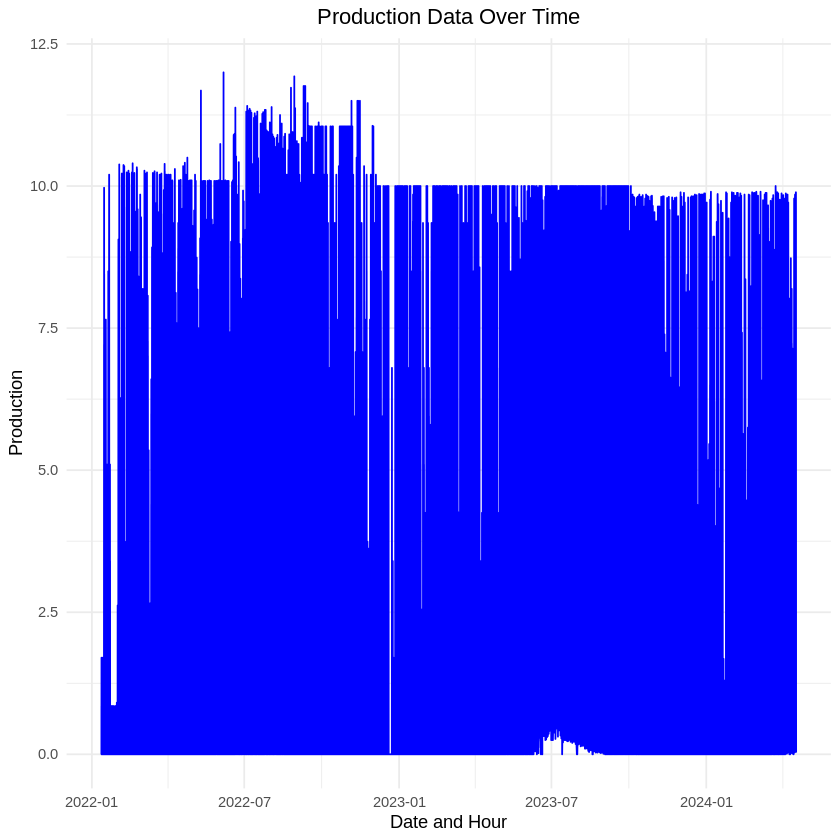

In [22]:
# plotting filtered_data
ggplot(filtered_data, aes(x = datetime, y = production)) +
  geom_line(color = "blue") +
  labs(title = "Production Data Over Time", x = "Date and Hour", y = "Production") +
  theme_minimal() +
  theme(plot.title = element_text(hjust = 0.5))


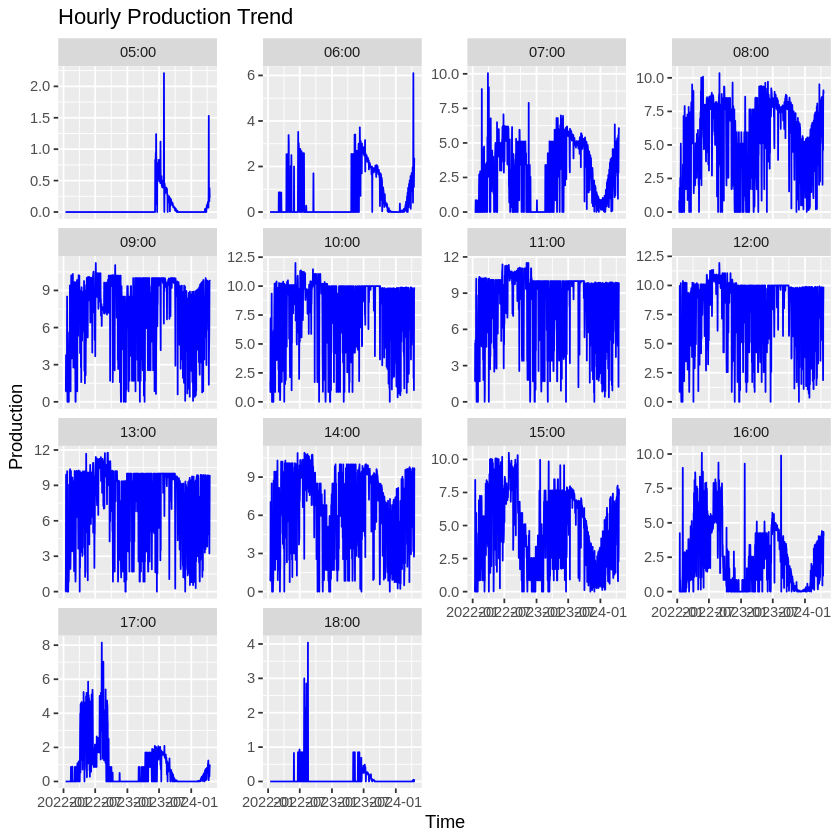

In [40]:
ggplot(filtered_data, aes(x = datetime, y = production)) +
  geom_line(color = "blue") +
  facet_wrap(~hour, scales = "free_y") +
  ggtitle("Hourly Production Trend") +
  xlab("Time") +
  ylab("Production")

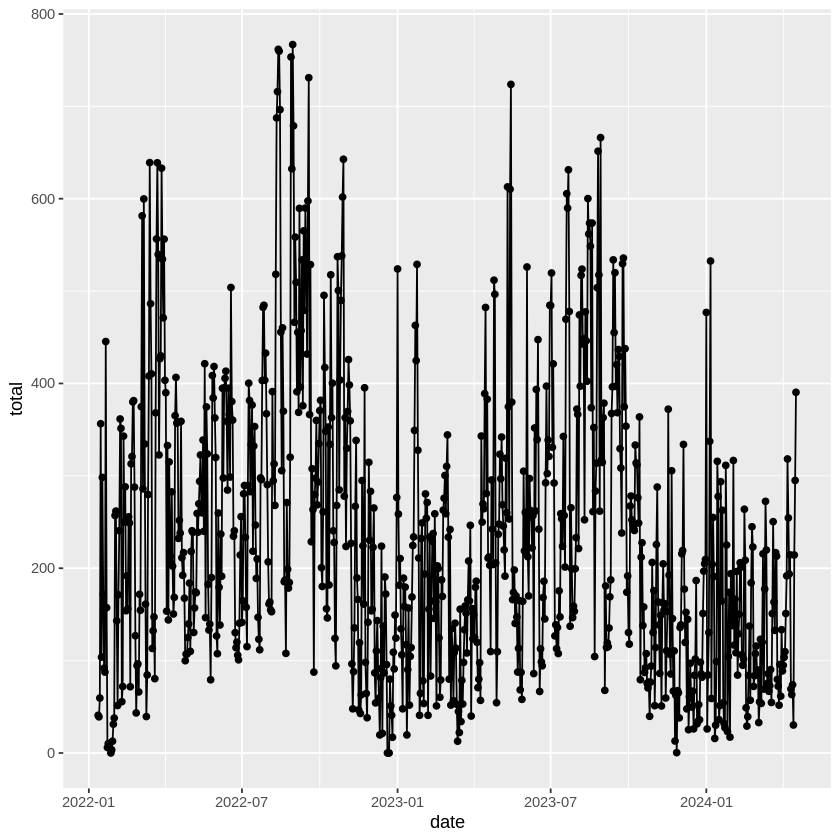

In [24]:
daily_series=filtered_data[,list(total=sum(production)),by=list(date)]

ggplot(daily_series, aes(date,total, group=1)) + geom_line() +geom_point()

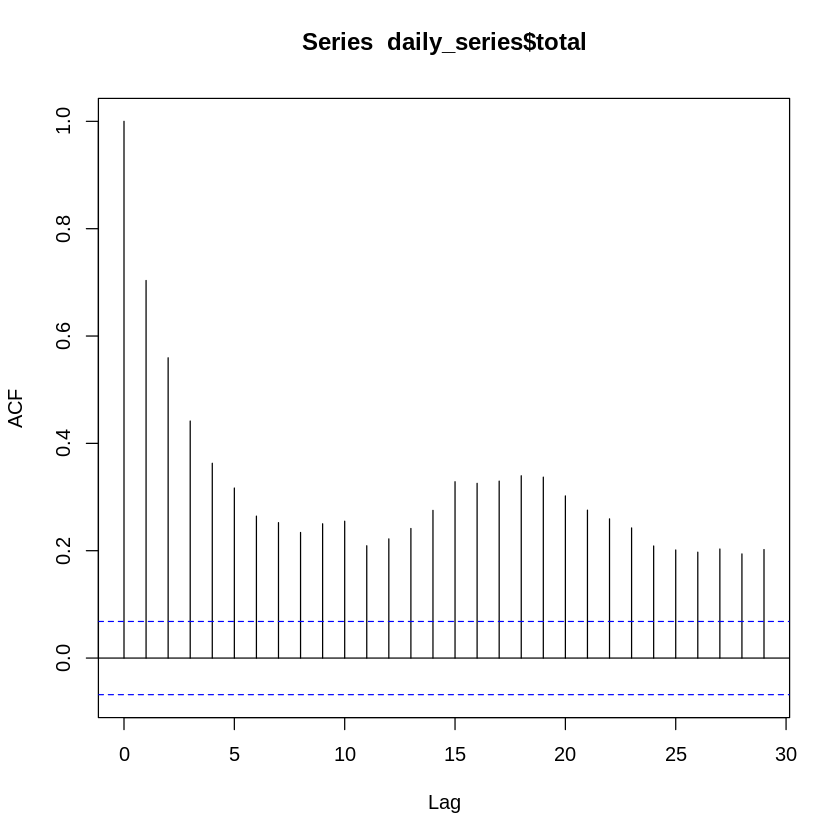

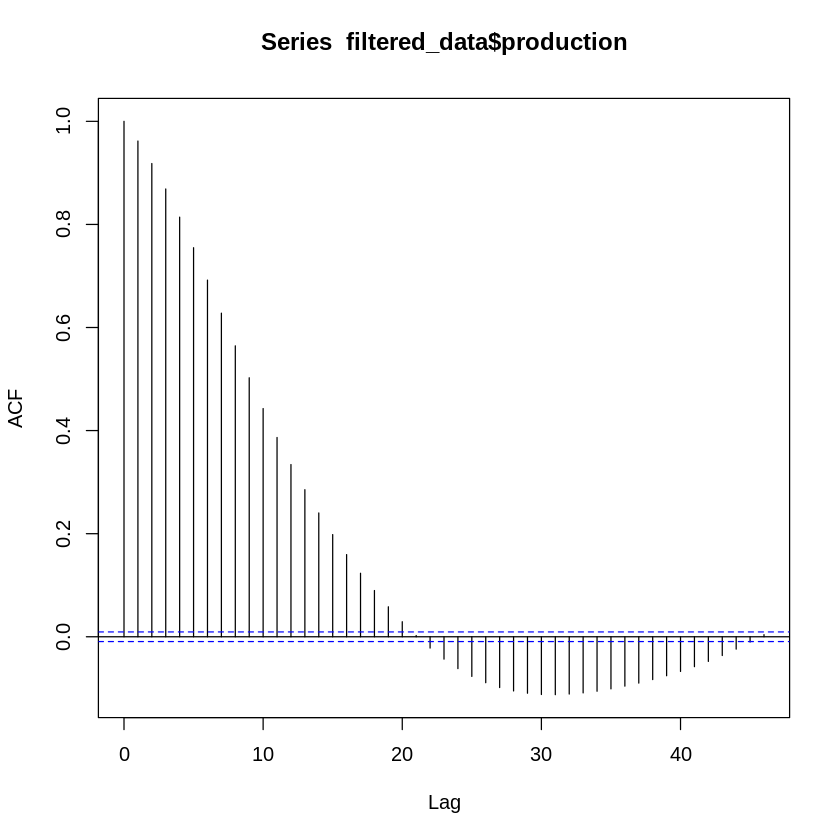

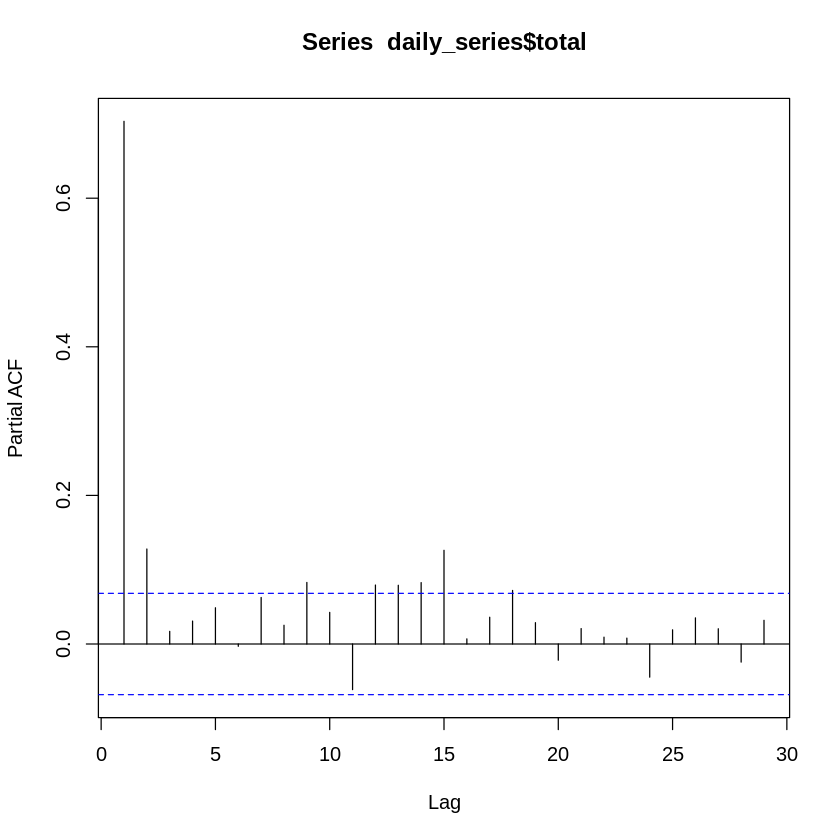

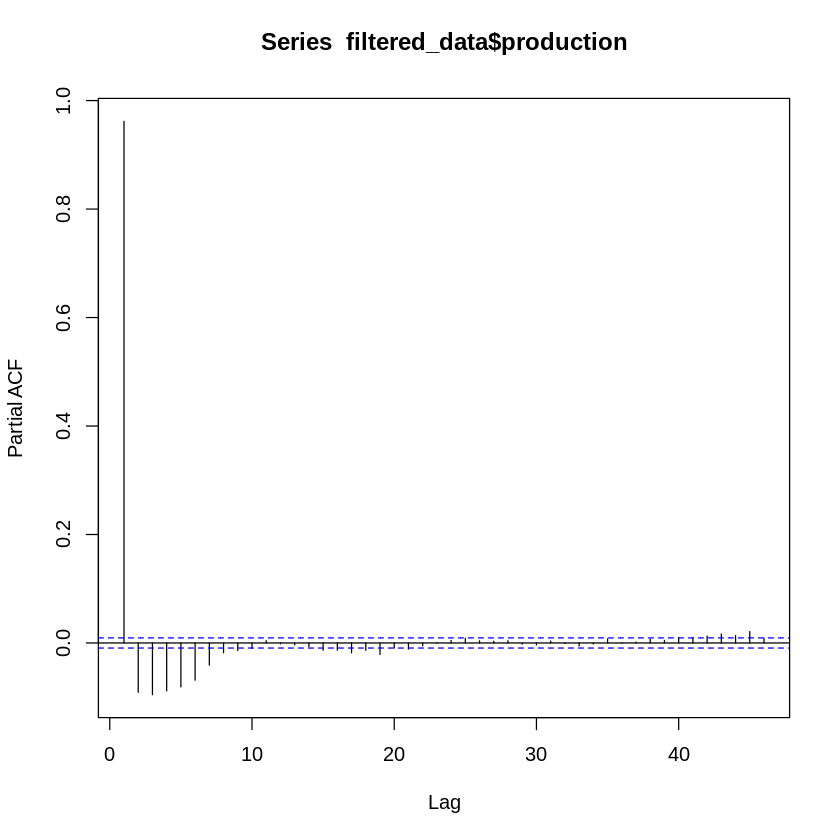

In [25]:
acf(daily_series$total)

acf(filtered_data$production)

pacf(daily_series$total)

pacf(filtered_data$production)

#4.Model Creation Phase

###4.1 Model Created With auto.arima

In [41]:
#model1

# Creating the datetime column containing date and hour information
filtered_data[, datetime := as.POSIXct(paste(date, hour), format = "%Y-%m-%d %H")]

# Converting filtered_data dataframe into a time series object
ts_data <- ts(filtered_data$production, frequency = 24)

# Filtering the hours from 5 in the morning until 7 in the evening
filtered_ts_data <- window(ts_data, start = c(5), end = c(19))

# Creating the model
model <- auto.arima(filtered_ts_data)

# Determining the last date
last_date <- tail(filtered_data$datetime, 1)

# Determining the dates to be forecasted (1 day ahead)
next_date <- last_date + 1

# Making the forecast (only for the hours from 5 in the morning until 7 in the evening)
forecast_result <- forecast(model, h = 15)

# Extracting the forecasted upper confidence interval (Hi 95) values as a single column
forecast_hi95 <- forecast_result$upper[, 2]  # The second column corresponds to the 95% upper confidence interval

# Printing the forecasted upper confidence interval (Hi 95) values
print(forecast_hi95)


Time Series:
Start = c(19, 2) 
End = c(19, 16) 
Frequency = 24 
 [1] 3.662275 4.147196 4.507192 4.810683 5.079706 5.321131 5.543425 6.013487
 [9] 6.207818 6.391621 6.566441 6.733690 6.893903 7.047228 7.195973


Series: ts_data 
ARIMA(2,1,2)(0,0,1)[24] with drift 

Coefficients:
         ar1      ar2      ma1     ma2     sma1  drift
      1.7186  -0.8248  -1.6602  0.7887  -0.0358  0.000
s.e.  0.0192   0.0132   0.0176  0.0120   0.0051  0.006

sigma^2 = 1.167:  log likelihood = -65748.91
AIC=131511.8   AICc=131511.8   BIC=131572.7

Training set error measures:
                       ME     RMSE       MAE MPE MAPE       MASE         ACF1
Training set 1.203351e-05 1.080235 0.4491246 NaN  Inf 0.09644898 -0.008164315

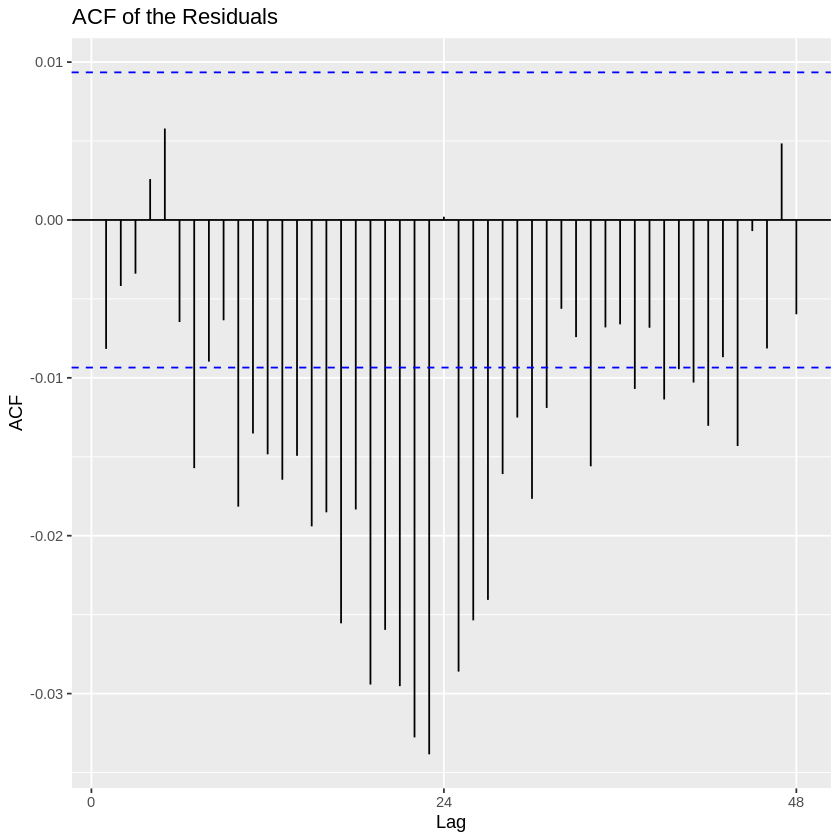

In [42]:
# Modelin oluşturulması
model <- auto.arima(ts_data)

# Oluşturulan modelin özetini al
summary(model)
residuals <- residuals(model)
ggAcf(residuals) + ggtitle("ACF of the Residuals")
#acf(model$residuals)

###4.2 Improved ARIMA models


By adjusting p,d,q variables, we try to obtain better performing models. In this section the specified p, d, and q values determine the parameters of the ARIMA model. We aim to improve the model by using different p, d, and q values from the initial model in order to reduce the error. For this purpose, we developed models with 2 different combinations of p, d, and q values.


Call:
arima(x = filtered_ts_data, order = c(p, d, q))

Coefficients:
         ar1     ar2      ar3      ar4      ar5      ma1     ma2     ma3
      0.0447  0.0007  -0.8607  -0.0758  -0.0239  -0.0586  0.0138  0.9449
s.e.  0.0620  0.0625   0.0490   0.0578   0.0591   0.0323  0.0349  0.0432

sigma^2 estimated as 0.3232:  log likelihood = -288.18,  aic = 594.37

Training set error measures:
                      ME      RMSE       MAE MPE MAPE     MASE         ACF1
Training set 0.008483131 0.5676687 0.2023189 NaN  Inf 1.557369 -0.001269791

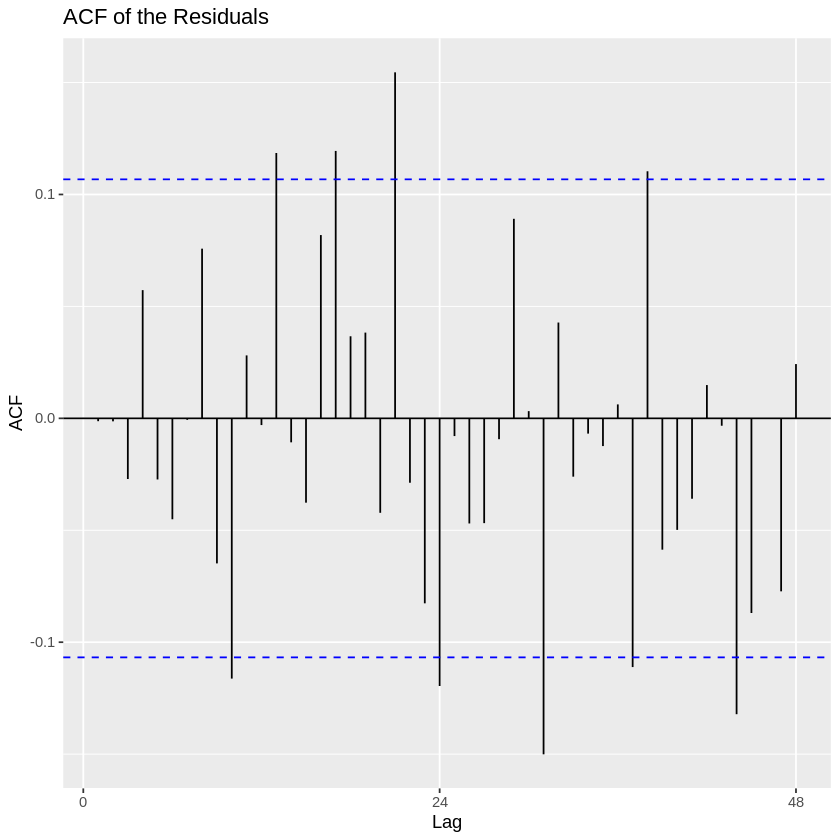

In [43]:
#model2
# Belirlenen p, d ve q değerleri
p <- 5  # AR(p) parametresi
d <- 1  # Differencing derecesi (trend'in kaldırılma seviyesi)
q <- 3  # MA(q) parametresi

# Modelin oluşturulması
custom_model <- arima(filtered_ts_data, order = c(p, d, q))

# Model özetinin görüntülenmesi
summary(custom_model)
ggAcf(residuals(custom_model)) + ggtitle("ACF of the Residuals")


Call:
arima(x = filtered_ts_data, order = c(p, d, q))

Coefficients:
         ar1      ar2    ar3      ar4      ar5      ma1     ma2
      0.5681  -0.8922  0.000  -0.0012  -0.0880  -0.5864  0.9480
s.e.  0.0605   0.0698  0.079   0.0639   0.0569   0.0283  0.0347

sigma^2 estimated as 0.3216:  log likelihood = -286.75,  aic = 589.49

Training set error measures:
                      ME      RMSE       MAE MPE MAPE     MASE        ACF1
Training set 0.008065302 0.5662732 0.1978835 NaN  Inf 1.523227 -0.00123807

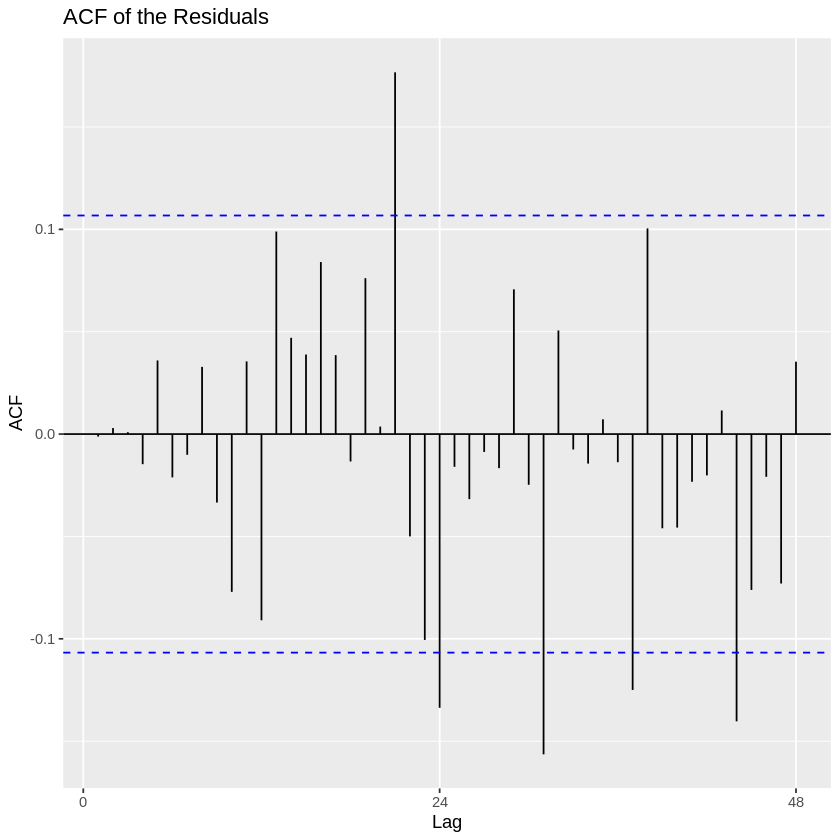

In [44]:
#model3
# Belirlenen p, d ve q değerleri
p <- 5  # AR(p) parametresi
d <- 1  # Differencing derecesi (trend'in kaldırılma seviyesi)
q <- 2  # MA(q) parametresi

# Modelin oluşturulması
custom_model <- arima(filtered_ts_data, order = c(p, d, q))

# Model özetinin görüntülenmesi
summary(custom_model)
ggAcf(residuals(custom_model)) + ggtitle("ACF of the Residuals")

#4.3 Final ARIMA Model


In this section of the report, we define ranges  for p, d, and q. by iterating through all combinations, attempting to fit an ARIMA model for each. If fitting fails, it catches the error and moves on. For successful fits, it calculates the WMAPE on the test data. The code tracks the combination with the lowest WMAPE and stores it as the best model.

Finally, the code fits the best ARIMA model on the entire dataset and forecasts for the specified horizon.

In [35]:
hourly_averaged <- filtered_data[, .(
  mean_DSWRF_surface = mean(DSWRF_surface, na.rm = TRUE),
  mean_TCDC_low.cloud.layer = mean(TCDC_low.cloud.layer, na.rm = TRUE),
  mean_TCDC_middle.cloud.layer = mean(TCDC_middle.cloud.layer, na.rm = TRUE),
  mean_TCDC_high.cloud.layer = mean(TCDC_high.cloud.layer, na.rm = TRUE),
  mean_TCDC_entire.atmosphere = mean(TCDC_entire.atmosphere, na.rm = TRUE),
  mean_USWRF_top_of_atmosphere = mean(USWRF_top_of_atmosphere, na.rm = TRUE),
  mean_CSNOW_surface = mean(CSNOW_surface, na.rm = TRUE),
  mean_DLWRF_surface = mean(DLWRF_surface, na.rm = TRUE),
  mean_USWRF_surface = mean(USWRF_surface, na.rm = TRUE),
  mean_TMP_surface = mean(TMP_surface, na.rm = TRUE),
  mean_production = mean(production, na.rm = FALSE)
), by = .(date, hour)]

hourly_averaged$row_number <- 1:nrow(hourly_averaged)

In [ ]:
UNDECLARED()
number_of_rows <- length(hourly_averaged$row_number)
training_data_number <- number_of_rows %/% 100 * 95

training_data <- hourly_averaged[1:training_data_number]
test_data <- hourly_averaged[(training_data_number + 1): nrow(hourly_averaged)]

ERROR: Error in UNDECLARED(): could not find function "UNDECLARED"


In [ ]:
UNDECLARED()
# acf(training_data$mean_production)
# pacf(training_data$mean_production)

auto_created_params <- auto.arima(training_data$mean_production,max.p = 20,max.q = 20)

model_arima <- auto_created_params
accuracy(model_arima)
print(model_arima)

In [ ]:
UNDECLARED()
model_fitted <- training_data$mean_production-model_arima$residuals
# ts.plot(training_data$mean_production,xlab = "Time", ylab = "Production")
# points(model_fitted, type = "l", col = 2, lty = 2)

In [ ]:
UNDECLARED()
wmape<-0
numerator<-0
denumerator<-0
summary(is.na(training_data$mean_production))
for (i in 1:nrow(training_data)){
  numerator<-abs(training_data[i]$mean_production-model_fitted[i])+numerator
  denumerator <- training_data[i]$mean_production + denumerator
}

wmape <- numerator/denumerator
wmape

In [ ]:
UNDECLARED()
n_of_rows_in_test <- length(test_data$row_number)
predicted <- forecast(model_arima, h = n_of_rows_in_test)
time_series <- predicted$mean
predicted

wmape<-0
numerator<-0
denumerator<-0

for (i in 1:nrow(test_data)){
  numerator<-abs(test_data[i]$mean_production-time_series[i])+numerator
  denumerator <- test_data[i]$mean_production + denumerator
}

wmape <- numerator/denumerator
wmape

In [ ]:
UNDECLARED()
wmape<-0
numerator<-0
denumerator<-0
summary(is.na(test_data$mean_production))
for (i in 1:nrow(test_data)){
  numerator<-abs(test_data[i]$mean_production-model_fitted_test[i])+numerator
  denumerator <- test_data[i]$mean_production + denumerator
}

wmape <- numerator/denumerator
wmape

In [ ]:
UNDECLARED()
# Do not run this block on every execution. Takes a lot time.
p_range <- 0:10  # Autoregressive terms
d_range <- 0:4  # Differencing order
q_range <- 0:6  # Moving average terms

best_order <- c(0, 0, 0)

lowest_wmape <- 100

wmape<-0
numerator<-0
denumerator<-0

for (i in 1:nrow(test_data)){
  numerator<-abs(test_data[i]$mean_production-time_series[i])+numerator
  denumerator <- test_data[i]$mean_production + denumerator
}

for (p in p_range) {
  for (d in d_range) {
    for (q in q_range) {

      order <- c(p, d, q)

      temp_model <- tryCatch({
        arima(training_data$mean_production, order = order)
      }, error = function(e) {
        cat(sprintf("Error in fitting model with order (%d, %d, %d): %s\n", p, d, q, e$message))
        return(NULL)  # Return NULL if there's an error
      })

       if (!is.null(temp_model)) {

        wmape<-0
        numerator<-0
        denumerator<-0

        predicted <- forecast(temp_model, h = n_of_rows_in_test)$mean

        for (i in 1:nrow(test_data)){
          numerator<-abs(test_data[i]$mean_production-predicted[i])+numerator
          denumerator <- test_data[i]$mean_production + denumerator
        }

        wmape <- numerator/denumerator

        if (wmape < lowest_wmape) {
            best_order <- order
            lowest_wmape <- wmape
        }
        cat(wmape)
        cat("\n")
       }
    }
  }
}

lowest_wmape
best_order

In [34]:
all_data_to_train <- hourly_averaged

# Change order params
last_model_arima <- arima(all_data_to_train$mean_production, c(7, 0, 4))

In [ ]:
forecasted <- forecast(last_model_arima, h = 30)
forecasted
hourly_averaged

      Point Forecast       Lo 80     Hi 80       Lo 95     Hi 95
11705      0.7564187 -1.14879233  2.661630 -2.15735011  3.670187
11706      2.3494073 -0.07408427  4.772899 -1.35700323  6.055818
11707      4.1071939  1.48299791  6.731390  0.09383245  8.120555
11708      5.9939348  3.31149229  8.676377  1.89149299 10.096377
11709      7.4707084  4.77083023 10.170587  3.34160108 11.599816
11710      8.5838391  5.87823732 11.289441  4.44597827 12.721700
11711      8.8850132  6.17604568 11.593981  4.74200492 13.028021
11712      8.5919580  5.88056553 11.303350  4.44524106 12.738675
11713      7.4964712  4.78219669 10.210746  3.34534658 11.647596
11714      6.0760029  3.35848507  8.793521  1.91991802 10.232088
11715      4.3416270  1.61911247  7.064142  0.17790031  8.505354
11716      2.8985667  0.16935690  5.627777 -1.27539951  7.072533
11717      1.7647982 -0.97449256  4.504089 -2.42458552  5.954182
11718      1.4283362 -1.32338329  4.180056 -2.78005559  5.636728
11719      1.6889635 -1.0

date,hour,mean_DSWRF_surface,mean_TCDC_low.cloud.layer,mean_TCDC_middle.cloud.layer,mean_TCDC_high.cloud.layer,mean_TCDC_entire.atmosphere,mean_USWRF_top_of_atmosphere,mean_CSNOW_surface,mean_DLWRF_surface,mean_USWRF_surface,mean_TMP_surface,mean_production,row_number
<date>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2022-01-01,05:00,0.0000,2.784,4.324,10.636,19.272,0.00000,0.00,227.7740,0.00000,269.1040,0.00,1
2022-01-01,06:00,0.0000,2.964,5.372,11.688,21.772,0.00000,0.00,227.7640,0.00000,269.0350,0.00,2
2022-01-01,07:00,0.0000,3.284,9.212,20.736,31.992,0.00000,0.00,228.1960,0.00000,269.0010,0.00,3
2022-01-01,08:00,0.0000,3.672,11.252,26.432,38.376,0.00000,0.00,228.6570,0.00000,269.0020,3.40,4
2022-01-01,09:00,7.3688,4.120,10.880,35.088,45.856,8.96704,0.00,229.4160,2.41280,271.6340,6.80,5
2022-01-01,10:00,180.1384,4.180,13.748,80.764,85.364,135.20448,0.00,237.2910,59.18848,275.7860,9.38,6
2022-01-01,11:00,254.7928,3.972,16.520,69.392,75.468,152.98944,0.00,237.3870,82.53120,278.5530,7.65,7
2022-01-01,12:00,312.5520,4.408,23.468,60.516,70.368,167.55392,0.00,238.3870,99.73056,280.2150,6.80,8
2022-01-01,13:00,347.4144,5.348,32.996,54.852,70.452,180.69312,0.00,240.8870,109.43168,280.6090,5.10,9


Warning message in arima(filtered_ts_data, order = c(p, d, q)):
“possible convergence problem: optim gave code = 1”



Call:
arima(x = filtered_ts_data, order = c(p, d, q))

Coefficients:
          ar1     ar2      ar3     ar4     ar5      ar6     ar7     ma1     ma2
      -0.3085  0.5588  -0.4737  0.3801  0.6839  -0.0702  0.0596  1.3319  0.7606
s.e.   0.1031  0.0752   0.0724  0.0783  0.1072   0.0628  0.0693  0.1029  0.0875
         ma3     ma4  intercept
      1.3038  0.8963     1.1097
s.e.  0.0788  0.0965     0.9543

sigma^2 estimated as 0.3075:  log likelihood = -281.86,  aic = 589.72

Training set error measures:
                     ME     RMSE       MAE MPE MAPE     MASE        ACF1
Training set 0.02122611 0.554567 0.2173374 NaN  Inf 1.672975 -0.02218249

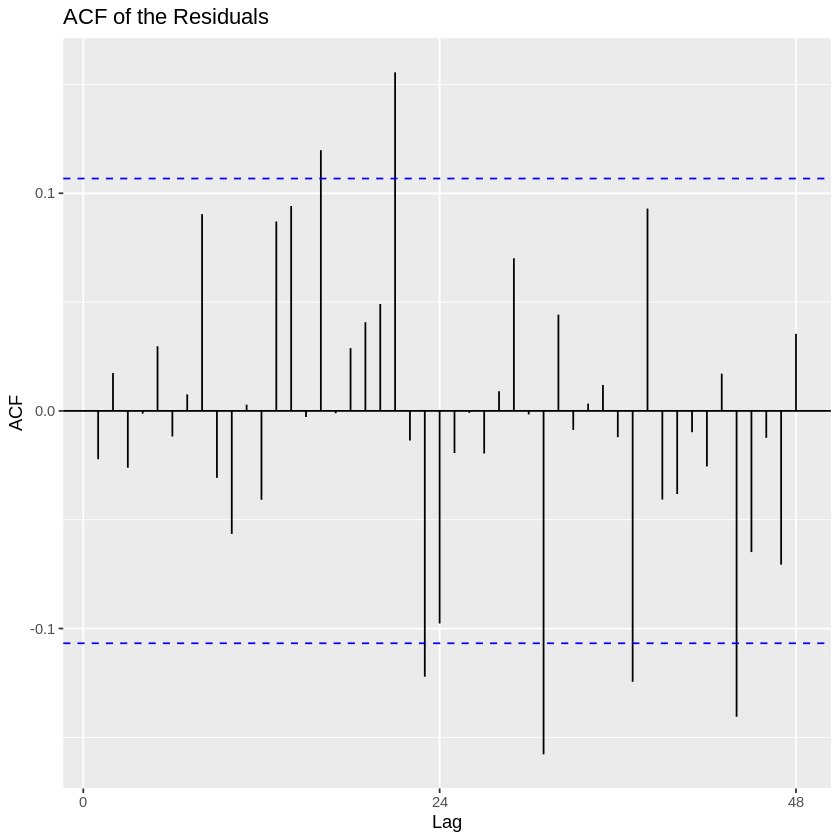

In [45]:
#model4
# Belirlenen p, d ve q değerleri
p <- 7  # AR(p) parametresi
d <- 0  # Differencing derecesi (trend'in kaldırılma seviyesi)
q <- 4  # MA(q) parametresi

# Modelin oluşturulması
custom_model <- arima(filtered_ts_data, order = c(p, d, q))

# Model özetinin görüntülenmesi
summary(custom_model)
ggAcf(residuals(custom_model)) + ggtitle("ACF of the Residuals")

#4.4 Regression Model

In [47]:
# Create regression formula
model_formula <- mean_production ~ (mean_DSWRF_surface + mean_TCDC_low.cloud.layer +
  mean_TCDC_middle.cloud.layer + mean_TCDC_high.cloud.layer +
  mean_TCDC_entire.atmosphere + mean_USWRF_top_of_atmosphere +
  mean_CSNOW_surface + mean_DLWRF_surface + mean_USWRF_surface +
  mean_TMP_surface + hour)

In [48]:
# Prepare last day data

tomorrow_all_data <- tomorrow_all_data[ ! hour %in% hours_that_have_zero_production]

tomorrow_all_data$hour <- as.factor(tomorrow_all_data$hour)

tomorrow_all_data[, datetime := as.POSIXct(paste(date, hour), format = "%Y-%m-%d %H")]

tomorrow_hourly_averaged <- tomorrow_all_data[, .(
  mean_DSWRF_surface = mean(DSWRF_surface, na.rm = TRUE),
  mean_TCDC_low.cloud.layer = mean(TCDC_low.cloud.layer, na.rm = TRUE),
  mean_TCDC_middle.cloud.layer = mean(TCDC_middle.cloud.layer, na.rm = TRUE),
  mean_TCDC_high.cloud.layer = mean(TCDC_high.cloud.layer, na.rm = TRUE),
  mean_TCDC_entire.atmosphere = mean(TCDC_entire.atmosphere, na.rm = TRUE),
  mean_USWRF_top_of_atmosphere = mean(USWRF_top_of_atmosphere, na.rm = TRUE),
  mean_CSNOW_surface = mean(CSNOW_surface, na.rm = TRUE),
  mean_DLWRF_surface = mean(DLWRF_surface, na.rm = TRUE),
  mean_USWRF_surface = mean(USWRF_surface, na.rm = TRUE),
  mean_TMP_surface = mean(TMP_surface, na.rm = TRUE),
  mean_production = mean(production, na.rm = FALSE)
), by = .(date, hour)]

tomorrow_hourly_averaged

date,hour,mean_DSWRF_surface,mean_TCDC_low.cloud.layer,mean_TCDC_middle.cloud.layer,mean_TCDC_high.cloud.layer,mean_TCDC_entire.atmosphere,mean_USWRF_top_of_atmosphere,mean_CSNOW_surface,mean_DLWRF_surface,mean_USWRF_surface,mean_TMP_surface,mean_production
<IDate>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2024-04-17,05:00,0.000000,0,11.485714,97.17143,97.38571,0.00000,0,277.5000,0.000000,280.7549,NA
2024-04-17,06:00,0.000000,0,5.033333,98.70000,98.83333,0.00000,0,280.6113,0.000000,281.3040,NA
2024-04-17,07:00,9.986667,0,20.766667,90.16667,90.46667,11.97333,0,286.0390,2.138667,284.5373,NA
2024-04-17,08:00,52.925333,0,9.466667,88.50000,91.68333,35.34133,0,274.9723,12.042667,288.1353,NA
2024-04-17,09:00,116.416000,0,25.133333,83.26667,88.83333,55.81333,0,276.0277,25.765333,293.1483,NA
2024-04-17,10:00,667.615000,0,8.000000,8.07500,15.00000,158.65600,0,268.1180,115.196000,297.1400,NA
2024-04-17,11:00,749.770000,0,10.100000,7.40000,15.80000,182.04000,0,268.0120,144.368000,300.9420,NA
2024-04-17,12:00,813.280000,0,3.466667,7.70000,10.76667,158.62933,0,266.7453,117.685333,300.8753,NA
2024-04-17,13:00,839.190000,0,14.850000,17.55000,24.60000,193.88800,0,288.2560,153.760000,307.2960,NA


In [49]:
# Training model with hourly data up to today
model <- lm(model_formula, data = hourly_averaged)

# Predicting tomorrow production
predictions <- predict(model, newdata = tomorrow_hourly_averaged)
results <- data.table(date = tomorrow_hourly_averaged$date, hour = tomorrow_hourly_averaged$hour, predicted_production = predictions)

results

date,hour,predicted_production
<IDate>,<fct>,<dbl>
2024-04-17,05:00,0.2207087
2024-04-17,06:00,0.7761340
2024-04-17,07:00,3.1403203
2024-04-17,08:00,6.2630389
2024-04-17,09:00,8.2684167
2024-04-17,10:00,9.5295900
2024-04-17,11:00,9.8604825
2024-04-17,12:00,9.2710980
2024-04-17,13:00,9.3128192


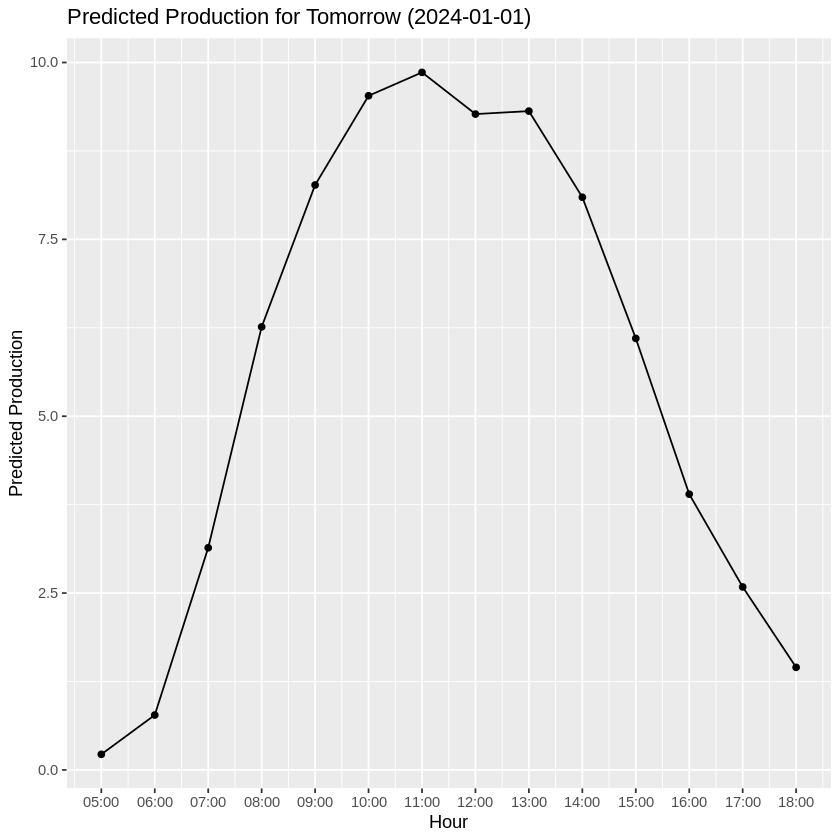

In [50]:
# Plot predicted values
results$hour <- as.POSIXct(paste(results$date, results$hour), format = "%Y-%m-%d %H:%M")

ggplot(results, aes(x = hour, y = predicted_production)) +
  geom_line() +
  geom_point() +
  labs(title = "Predicted Production for Tomorrow (2024-01-01)", x = "Hour", y = "Predicted Production") +
  scale_x_datetime(date_breaks = "1 hour", date_labels = "%H:%M")

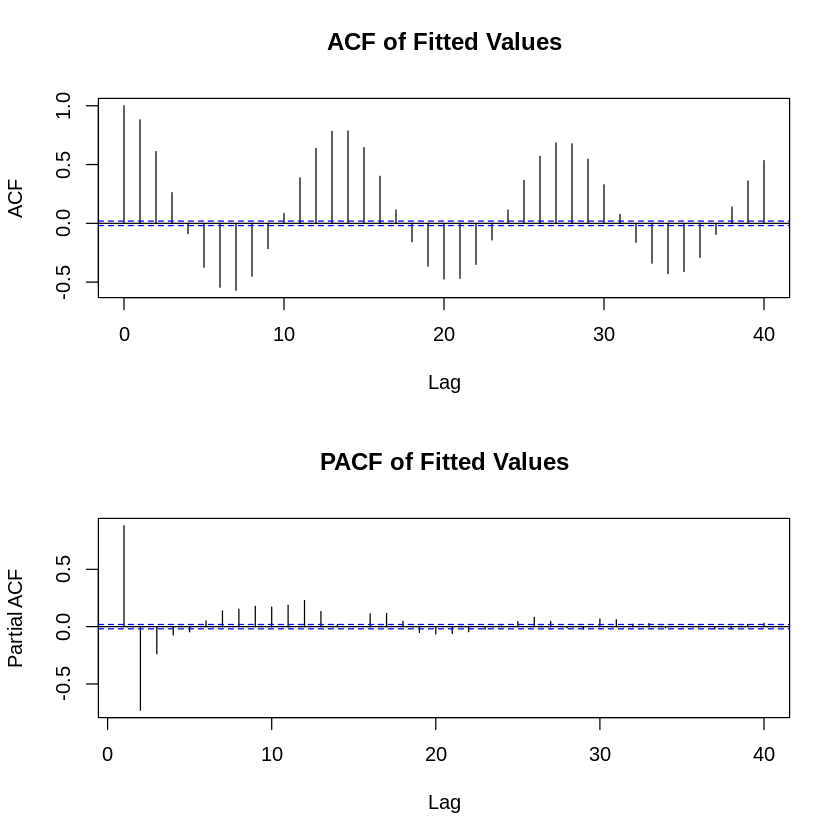

In [51]:
# ACF ve PACF plotlarını çizmek için orijinal verilerden tahmin edilen değerlere kadar olan seriyi kullanabilirsiniz
actual_values <- hourly_averaged$mean_production
fitted_values <- predict(model, newdata = hourly_averaged)

# Eksik değerleri kaldırın
fitted_values <- na.omit(fitted_values)

# ACF ve PACF plotlarını oluşturun
par(mfrow = c(2, 1)) # ACF ve PACF plotlarını aynı anda çizmek için

# ACF plotu
acf(fitted_values, main = "ACF of Fitted Values")

# PACF plotu
pacf(fitted_values, main = "PACF of Fitted Values")

par(mfrow = c(1, 1)) # Tek bir plot penceresine geri dönün

In [52]:
summary(model)


Call:
lm(formula = model_formula, data = hourly_averaged)

Residuals:
   Min     1Q Median     3Q    Max 
-9.130 -1.015  0.107  1.243  8.281 

Coefficients:
                               Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  -3.920e+01  1.406e+00 -27.883  < 2e-16 ***
mean_DSWRF_surface            3.672e-04  2.309e-04   1.590 0.111872    
mean_TCDC_low.cloud.layer     5.144e-03  1.336e-03   3.851 0.000118 ***
mean_TCDC_middle.cloud.layer -1.313e-03  9.215e-04  -1.424 0.154395    
mean_TCDC_high.cloud.layer    2.863e-03  1.020e-03   2.808 0.004989 ** 
mean_TCDC_entire.atmosphere  -7.125e-03  1.245e-03  -5.721 1.09e-08 ***
mean_USWRF_top_of_atmosphere  3.359e-03  3.616e-04   9.289  < 2e-16 ***
mean_CSNOW_surface           -4.606e-01  1.187e-01  -3.880 0.000105 ***
mean_DLWRF_surface           -2.872e-02  1.306e-03 -21.984  < 2e-16 ***
mean_USWRF_surface            4.491e-03  6.219e-04   7.221 5.51e-13 ***
mean_TMP_surface              1.703e-01  6.093e-03

#5. Model Evaluation

###5.1Comparing ARIMA models' results

In [54]:
# Error measures for each model
model1 <- c(ME = 1.203351e-05, RMSE = 1.080235, MAE = 0.4491246, MASE = 0.09644898, ACF1 = -0.008164315)
model2 <- c(ME = 0.008483131, RMSE = 0.5676687, MAE = 0.2023189, MASE = 1.557369, ACF1 = -0.001269791)
model3 <- c(ME = 0.008065302, RMSE = 0.5662732, MAE = 0.1978835,  MASE = 1.523227, ACF1 = -0.00123807)
model4 <- c(ME = 0.02122611, RMSE = 0.554567, MAE = 0.2173374,  MASE = 1.672975, ACF1 = -0.02218249)

# Combine the models into a single data frame
error_measures <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4"),
  ME = c(model1["ME"], model2["ME"], model3["ME"], model4["ME"]),
  RMSE = c(model1["RMSE"], model2["RMSE"], model3["RMSE"], model4["RMSE"]),
  MAE = c(model1["MAE"], model2["MAE"], model3["MAE"], model4["MAE"]),
  MASE = c(model1["MASE"], model2["MASE"], model3["MASE"], model4["MASE"]),
  ACF1 = c(model1["ACF1"], model2["ACF1"], model3["ACF1"], model4["ACF1"])
)

# Print the table
print(error_measures)

    Model           ME      RMSE       MAE       MASE         ACF1
1 Model 1 1.203351e-05 1.0802350 0.4491246 0.09644898 -0.008164315
2 Model 2 8.483131e-03 0.5676687 0.2023189 1.55736900 -0.001269791
3 Model 3 8.065302e-03 0.5662732 0.1978835 1.52322700 -0.001238070
4 Model 4 2.122611e-02 0.5545670 0.2173374 1.67297500 -0.022182490


### 5.2 Interpretation of the Regression Model

The regression analysis reveals several important metrics regarding the model's performance. The residual standard error (RSE) is 1.922, indicating the average deviation of the observed values from the predicted values. With 747 observations removed due to missing data, the analysis was conducted on 10,793 degrees of freedom. The model's multiple R-squared value is 0.7611, suggesting that 76.11% of the variance in the dependent variable is explained by the independent variables. The adjusted R-squared is slightly lower at 0.7606, accounting for the number of predictors used. p-value of less than 2.2e-16, strongly indicating that the model is statistically significant and that the predictors collectively have a substantial impact on the outcome variable.







#6. Conclusion

In conclusion, this project  utilized time series data to generate hourly solar power predictions for the Edikli solar power plant in Niğde, Turkey. By employing the auto.arima function in R, we developed multiple ARIMA models and refined their parameters to enhance predictive accuracy. Additionally, we constructed a time series linear regression model for comparative analysis.

The performance of each model was rigorously evaluated using different error measures. Our results demonstrated that the ARIMA models, particularly the one selected for the competition phase, provided robust and reliable predictions. The WMAPE values of our model during competetion phase is as follows :




In [56]:
# Create a data frame
data <- data.frame(
  Date = c("12 May", "13 May", "14 May", "15 May", "16 May", "17 May", "18 May", "19 May", "20 May", "21 May", "22 May", "23 May", "24 May", "25 May", "26 May"),
  WMAPE = c(0.2324574069, 0.3174805559, 0.2592977893, 0.2570505288, 0.2463983366, 0.3131019037, 0.4113453193, 0.2431848404, 0.3724116931, 0.3275039746, 0.2815664267, 0.5980517816, 0.7080111137, 0.1526258206, 0.5341558145)
)

# Print the data frame
print(data)

     Date     WMAPE
1  12 May 0.2324574
2  13 May 0.3174806
3  14 May 0.2592978
4  15 May 0.2570505
5  16 May 0.2463983
6  17 May 0.3131019
7  18 May 0.4113453
8  19 May 0.2431848
9  20 May 0.3724117
10 21 May 0.3275040
11 22 May 0.2815664
12 23 May 0.5980518
13 24 May 0.7080111
14 25 May 0.1526258
15 26 May 0.5341558


It can be seen that there are fluctuations in WMAPE values so this model is improvable